In [63]:
import numpy as np
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.datasets import cifar10 # to load dataset

from utils import compute_stats, get_grad
from MB_LBFGS import LBFGS
import BB_DL

import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
from time import time
from tqdm import notebook

import pandas as pd

In [31]:
max_iter = 15 * (50000 // 256)                      # note each iteration is NOT an epoch
ghost_batch = 128
overlap_ratio = 0.25                # should be in (0, 0.5)
lr = 1.0

In [42]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

In [33]:
X_train.shape, X_test.shape

((50000, 3, 32, 32), (10000, 3, 32, 32))

In [34]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
cuda = torch.cuda.is_available()
    
#%% Create neural network model
        
if(cuda):
    torch.cuda.manual_seed(2018)
    model = ConvNet().cuda() 
else:
    torch.manual_seed(2018)
    model = ConvNet()
    
#%% Define helper functions

# Forward pass
if(cuda):
    opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
else:
    opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
if(cuda):
    predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
else:
    predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze()))*100

In [36]:
train_losses = {}
val_losses = {}
val_accs = {}
times = {}

In [37]:
batch_size = 256
optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, line_search='None', debug=True)
epoch = 0

opt_name = 'LBFGS'
train_losses[opt_name] = []
val_losses[opt_name] = []
val_accs[opt_name] = []
#%% Main training loop

Ok_size = int(overlap_ratio*batch_size)
Nk_size = int((1 - 2*overlap_ratio)*batch_size)

# sample previous overlap gradient
random_index = np.random.permutation(range(X_train.shape[0]))
Ok_prev = random_index[0:Ok_size]
g_Ok_prev, obj_Ok_prev = get_grad(optimizer, X_train[Ok_prev], y_train[Ok_prev], opfun)

time0 = time()

for n_iter in notebook.tqdm(range(max_iter)):
    
    # sample current non-overlap and next overlap gradient
    random_index = np.random.permutation(range(X_train.shape[0]))
    Ok = random_index[0:Ok_size]
    Nk = random_index[Ok_size:(Ok_size + Nk_size)]
    
    # compute overlap gradient and objective
    g_Ok, obj_Ok = get_grad(optimizer, X_train[Ok], y_train[Ok], opfun)
    
    # compute non-overlap gradient and objective
    g_Nk, obj_Nk = get_grad(optimizer, X_train[Nk], y_train[Nk], opfun)
    
    # compute accumulated gradient over sample
    g_Sk = overlap_ratio*(g_Ok_prev + g_Ok) + (1 - 2*overlap_ratio)*g_Nk
        
    # two-loop recursion to compute search direction
    p = optimizer.two_loop_recursion(-g_Sk)
                
    # perform line search step
    lr = optimizer.step(p, g_Ok, g_Sk=g_Sk)
    
    # compute previous overlap gradient for next sample
    Ok_prev = Ok
    g_Ok_prev, obj_Ok_prev = get_grad(optimizer, X_train[Ok_prev], y_train[Ok_prev], opfun)
    
    # curvature update
    optimizer.curvature_update(g_Ok_prev, eps=0.2, damping=True)
    
    # compute statistics
    if n_iter % (50000 // 256) == 0:
        epoch += 1
        with torch.no_grad():
            train_loss, test_loss, test_acc = compute_stats(X_train, y_train, X_test, 
                                                            y_test, opfun, accfun, ghost_batch=128)
            train_losses[opt_name].append(train_loss)
            val_losses[opt_name].append(test_loss)
            val_accs[opt_name].append(test_acc)
            print('Epoch:', epoch, 'lr:', lr, 'Training Loss:', train_loss, 
                  'Test Loss:', test_loss, 'Test Accuracy:', test_acc)
            
times[opt_name] = (time()-time0)/60

Epoch: 1 lr: 1.0 Training Loss: 2.307020727233886 Test Loss: 2.307208023881912 Test Accuracy: 10.06
Applying Powell damping...
Applying Powell damping...
Epoch: 2 lr: 1.0 Training Loss: 1.7486615343022345 Test Loss: 1.7433395506620413 Test Accuracy: 36.48000000000001
Epoch: 3 lr: 1.0 Training Loss: 1.683805628044605 Test Loss: 1.6765074175238606 Test Accuracy: 39.54000000000001
Epoch: 4 lr: 1.0 Training Loss: 1.673443011968136 Test Loss: 1.6678930559873573 Test Accuracy: 39.43
Applying Powell damping...
Epoch: 5 lr: 1.0 Training Loss: 1.6454241621065135 Test Loss: 1.6412503375411038 Test Accuracy: 40.339999999999996
Epoch: 6 lr: 1.0 Training Loss: 1.6281926880145077 Test Loss: 1.6259743942022329 Test Accuracy: 40.92000000000001
Epoch: 7 lr: 1.0 Training Loss: 1.5923048008227343 Test Loss: 1.591374859058857 Test Accuracy: 42.64000000000001
Epoch: 8 lr: 1.0 Training Loss: 1.5726911663222318 Test Loss: 1.5748964718103409 Test Accuracy: 42.87000000000002
Epoch: 9 lr: 1.0 Training Loss: 1.5

In [48]:
train_losses.pop('Adam')
val_losses.pop('Adam')
val_accs.pop('Adam')

[10.0,
 10.01,
 10.229999999999999,
 10.160000000000002,
 12.430000000000001,
 14.770000000000003,
 15.069999999999999,
 14.920000000000003,
 14.220000000000008,
 14.010000000000002,
 13.670000000000003,
 13.820000000000002,
 15.040000000000008,
 18.88,
 23.8,
 22.33,
 24.220000000000002,
 25.76,
 21.21,
 21.109999999999992,
 26.409999999999993,
 29.070000000000007]

In [49]:
cuda = torch.cuda.is_available()
    
#%% Create neural network model
        
if(cuda):
    torch.cuda.manual_seed(2018)
    model = ConvNet().cuda() 
else:
    torch.manual_seed(2018)
    model = ConvNet()
    
#%% Define helper functions

# Forward pass
if(cuda):
    opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
else:
    opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
if(cuda):
    predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
else:
    predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze()))*100

In [50]:
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch = 0

opt_name = 'Adam'
train_losses[opt_name] = []
val_losses[opt_name] = []
val_accs[opt_name] = []

time0 = time()
for n_iter in notebook.tqdm(range(max_iter)):
    
    # sample current non-overlap and next overlap gradient
    random_index = np.random.permutation(range(X_train.shape[0]))
    idx = random_index[0:batch_size]
    optimizer.zero_grad()
    
    X_batch = torch.from_numpy(X_train[idx])
    y_batch = torch.from_numpy(y_train[idx]).long().squeeze()
    
    loss = F.cross_entropy(model(X_batch), y_batch)
    loss.backward()
    
    optimizer.step()
    
    # compute statistics
    if n_iter % (50000 // 256) == 0:
        epoch += 1
        with torch.no_grad():
            train_loss, test_loss, test_acc = compute_stats(X_train,
                                                            y_train,
                                                            X_test, 
                                                            y_test,
                                                            opfun,
                                                            accfun,
                                                            ghost_batch=128)
            train_losses[opt_name].append(train_loss)
            val_losses[opt_name].append(test_loss)
            val_accs[opt_name].append(test_acc)
            
            print('Epoch:', epoch, 'lr:', lr, 'Training Loss:', train_loss, 
                  'Test Loss:', test_loss, 'Test Accuracy:', test_acc)
times[opt_name] = (time()-time0)/60

Epoch: 1 lr: 1.0 Training Loss: 2.2988063698625556 Test Loss: 2.298778538632393 Test Accuracy: 15.129999999999997
Epoch: 2 lr: 1.0 Training Loss: 1.552318742520809 Test Loss: 1.5590766340017321 Test Accuracy: 43.300000000000004
Epoch: 3 lr: 1.0 Training Loss: 1.4221056767845146 Test Loss: 1.430255174255371 Test Accuracy: 48.260000000000005
Epoch: 4 lr: 1.0 Training Loss: 1.3567888640117642 Test Loss: 1.3736087328910824 Test Accuracy: 50.15999999999999
Epoch: 5 lr: 1.0 Training Loss: 1.2748211928820612 Test Loss: 1.3034065047144896 Test Accuracy: 52.82999999999999
Epoch: 6 lr: 1.0 Training Loss: 1.2271309779310222 Test Loss: 1.2736925243139265 Test Accuracy: 54.33999999999999
Epoch: 7 lr: 1.0 Training Loss: 1.1657160998415945 Test Loss: 1.2293749202966693 Test Accuracy: 56.06999999999999
Epoch: 8 lr: 1.0 Training Loss: 1.1261323582863807 Test Loss: 1.2105850484728813 Test Accuracy: 56.79999999999996
Epoch: 9 lr: 1.0 Training Loss: 1.0921691640400886 Test Loss: 1.1972853396534915 Test Ac

In [51]:
cuda = torch.cuda.is_available()
    
#%% Create neural network model
        
if(cuda):
    torch.cuda.manual_seed(2018)
    model = ConvNet().cuda() 
else:
    torch.manual_seed(2018)
    model = ConvNet()
    
#%% Define helper functions

# Forward pass
if(cuda):
    opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
else:
    opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
if(cuda):
    predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
else:
    predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze()))*100

In [53]:
batch_size = 256
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.003)

epoch = 0

opt_name = 'SGD'
train_losses[opt_name] = []
val_losses[opt_name] = []
val_accs[opt_name] = []

time0 = time()
for n_iter in notebook.tqdm(range(max_iter)):
    
    # sample current non-overlap and next overlap gradient
    random_index = np.random.permutation(range(X_train.shape[0]))
    idx = random_index[0:batch_size]
    optimizer.zero_grad()
    
    X_batch = torch.from_numpy(X_train[idx])
    y_batch = torch.from_numpy(y_train[idx]).long().squeeze()
    
    loss = F.cross_entropy(model(X_batch), y_batch)
    loss.backward()
    
    optimizer.step()
    
    # compute statistics
    if n_iter % (50000 // 256) == 0:
        epoch += 1
        with torch.no_grad():
            train_loss, test_loss, test_acc = compute_stats(X_train,
                                                            y_train,
                                                            X_test, 
                                                            y_test,
                                                            opfun,
                                                            accfun,
                                                            ghost_batch=128)
            train_losses[opt_name].append(train_loss)
            val_losses[opt_name].append(test_loss)
            val_accs[opt_name].append(test_acc)
            
            print('Epoch:', epoch, 'lr:', lr, 'Training Loss:', train_loss, 
                  'Test Loss:', test_loss, 'Test Accuracy:', test_acc)
times[opt_name] = (time()-time0)/60

Epoch: 1 lr: 1.0 Training Loss: 2.302907994699478 Test Loss: 2.30286853094101 Test Accuracy: 10.53
Epoch: 2 lr: 1.0 Training Loss: 2.3009514142227165 Test Loss: 2.3008914939165117 Test Accuracy: 11.77
Epoch: 3 lr: 1.0 Training Loss: 2.298938544087411 Test Loss: 2.298850434660912 Test Accuracy: 10.65
Epoch: 4 lr: 1.0 Training Loss: 2.29639647345543 Test Loss: 2.2962721665620798 Test Accuracy: 10.249999999999998
Epoch: 5 lr: 1.0 Training Loss: 2.2931701890563967 Test Loss: 2.293006380558014 Test Accuracy: 10.13
Epoch: 6 lr: 1.0 Training Loss: 2.288764850478173 Test Loss: 2.288570636868477 Test Accuracy: 10.140000000000004
Epoch: 7 lr: 1.0 Training Loss: 2.2830159697151178 Test Loss: 2.282771533846857 Test Accuracy: 12.780000000000003
Epoch: 8 lr: 1.0 Training Loss: 2.2753410717535023 Test Loss: 2.275096709799767 Test Accuracy: 13.590000000000005
Epoch: 9 lr: 1.0 Training Loss: 2.26450020365715 Test Loss: 2.2643760766983028 Test Accuracy: 12.8
Epoch: 10 lr: 1.0 Training Loss: 2.2484722624

In [54]:
cuda = torch.cuda.is_available()
    
#%% Create neural network model
        
if(cuda):
    torch.cuda.manual_seed(2018)
    model = ConvNet().cuda() 
else:
    torch.manual_seed(2018)
    model = ConvNet()
    
#%% Define helper functions

# Forward pass
if(cuda):
    opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
else:
    opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
if(cuda):
    predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
else:
    predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze()))*100

In [57]:
batch_size = 256
optimizer = BB_DL.BB(model.parameters(), 
                     lr=0.003, 
                     steps=50000//256, 
                     beta=4. / (50000//256), 
                     max_lr=1, min_lr=1e-5)

epoch = 0

opt_name = 'BB'
train_losses[opt_name] = []
val_losses[opt_name] = []
val_accs[opt_name] = []

time0 = time()
for n_iter in notebook.tqdm(range(max_iter)):
    
    # sample current non-overlap and next overlap gradient
    random_index = np.random.permutation(range(X_train.shape[0]))
    idx = random_index[0:batch_size]
    optimizer.zero_grad()
    
    X_batch = torch.from_numpy(X_train[idx])
    y_batch = torch.from_numpy(y_train[idx]).long().squeeze()
    
    loss = F.cross_entropy(model(X_batch), y_batch)
    loss.backward()
    
    optimizer.step()
    
    # compute statistics
    if n_iter % (50000 // 256) == 0:
        epoch += 1
        with torch.no_grad():
            train_loss, test_loss, test_acc = compute_stats(X_train,
                                                            y_train,
                                                            X_test, 
                                                            y_test,
                                                            opfun,
                                                            accfun,
                                                            ghost_batch=128)
            train_losses[opt_name].append(train_loss)
            val_losses[opt_name].append(test_loss)
            val_accs[opt_name].append(test_acc)
            
            print('Epoch:', epoch, 'lr:', lr, 'Training Loss:', train_loss, 
                  'Test Loss:', test_loss, 'Test Accuracy:', test_acc)
times[opt_name] = (time()-time0)/60

Epoch: 1 lr: 1.0 Training Loss: 2.3029094750928882 Test Loss: 2.302870213580131 Test Accuracy: 10.510000000000002
Epoch: 2 lr: 1.0 Training Loss: 2.3009870283842093 Test Loss: 2.3009296103954306 Test Accuracy: 12.360000000000007
Epoch: 3 lr: 1.0 Training Loss: 2.298917750492097 Test Loss: 2.298838807249069 Test Accuracy: 10.479999999999995
Epoch: 4 lr: 1.0 Training Loss: 2.139878193807601 Test Loss: 2.14038070678711 Test Accuracy: 22.940000000000005
Epoch: 5 lr: 1.0 Training Loss: 4.135839676556587 Test Loss: 4.164681642580035 Test Accuracy: 13.610000000000005
Epoch: 6 lr: 1.0 Training Loss: 2.3022988937568662 Test Loss: 2.3023017862796786 Test Accuracy: 10.049999999999997
Epoch: 7 lr: 1.0 Training Loss: 2.0857668072080613 Test Loss: 2.0860279823780057 Test Accuracy: 26.349999999999987
Epoch: 8 lr: 1.0 Training Loss: 1.9842200491666802 Test Loss: 1.9850652876377104 Test Accuracy: 28.580000000000016
Epoch: 9 lr: 1.0 Training Loss: 1.6680061802768713 Test Loss: 1.6756049283623695 Test Ac

In [71]:
def plot_train_losses(losses):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in losses.keys():
            plt.plot(np.arange(len(losses[opt])) + 1, losses[opt], '--o', label=opt, linewidth=7)
        plt.xticks(np.arange(len(losses['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Loss on CIFAR-10 Train set', fontsize=30)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Loss', size=24)
    plt.show()
    f.savefig("cifar_train_losses.pdf", bbox_inches='tight')


def plot_val_losses(losses):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in losses.keys():
            plt.plot(np.arange(len(losses[opt])) + 1, losses[opt], '--o' , label=opt, linewidth=7)
        plt.xticks(np.arange(len(losses['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Loss on CIFAR-10 Validation set', fontsize=30)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Loss', size=24)
    plt.show()
    f.savefig("cifar_val_losses.pdf", bbox_inches='tight')
    

def plot_val_accuracy(accs):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in accs.keys():
            plt.plot(np.arange(len(accs[opt])) + 1, accs[opt], '--o', label=opt, linewidth=7)
        plt.xticks(np.arange(len(accs['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Accuracy on CIFAR-10 Validation set', fontsize=25)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Accuracy, %', size=24)
    plt.show()
    f.savefig("cifar_val_accuracy.pdf", bbox_inches='tight')

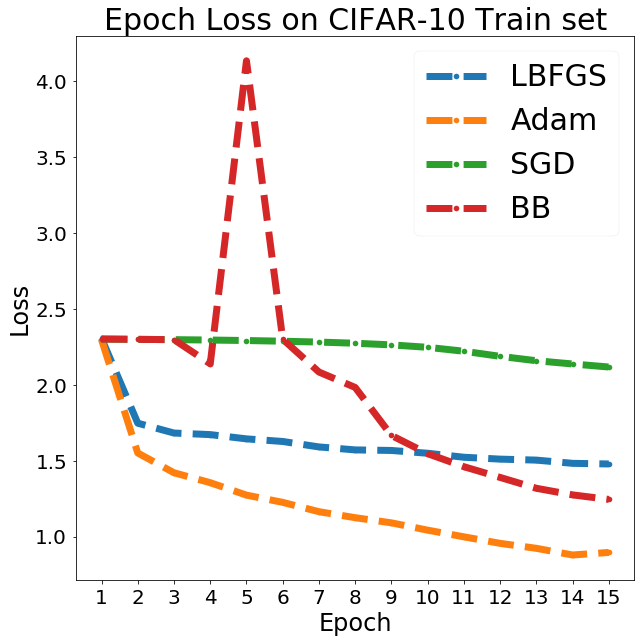

In [72]:
plot_train_losses(train_losses)

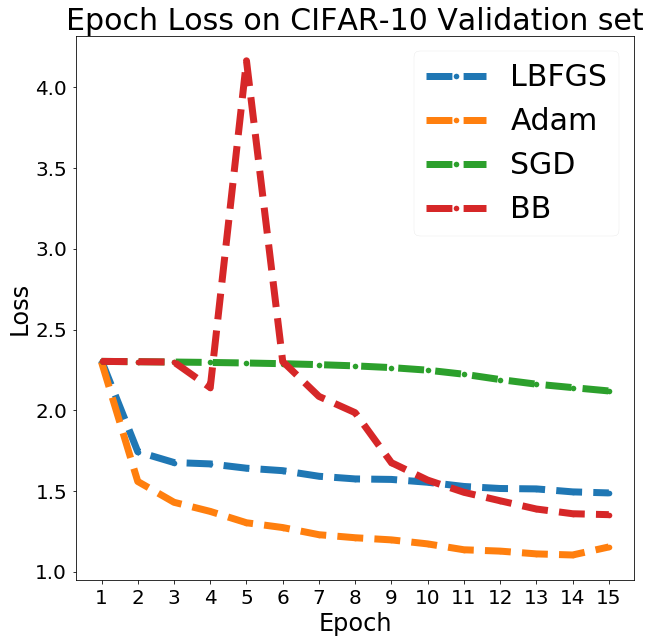

In [73]:
plot_val_losses(val_losses)

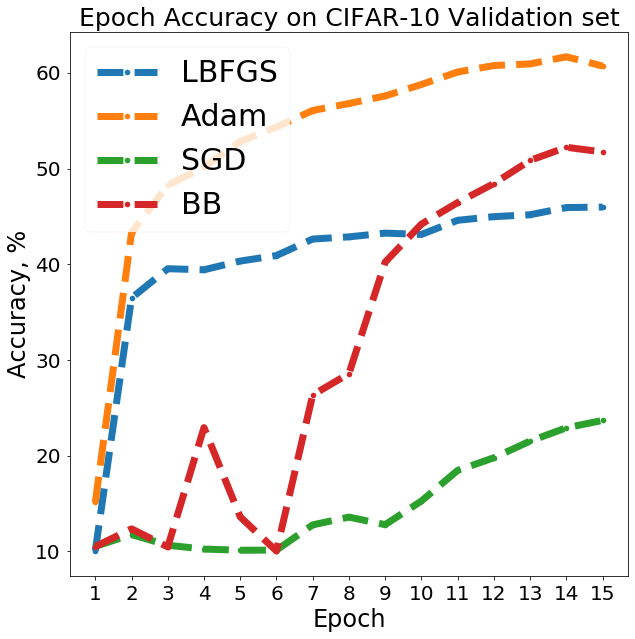

In [74]:
plot_val_accuracy(val_accs)

In [64]:
t = pd.DataFrame()
t['Optimizer'] = times.keys()
t['Time'] = times.values()
t['Acc 5'] = np.array(list(val_accs.values()))[:,4]
t['Acc 10'] = np.array(list(val_accs.values()))[:,9]
t['Acc 15'] = np.array(list(val_accs.values()))[:,14]

In [65]:
t

,Optimizer,Time,Acc 5,Acc 10,Acc 15
0,LBFGS,6.992177,40.34,43.12,45.98
1,Adam,5.483592,52.83,58.79,60.72
2,SGD,5.183617,10.13,15.27,23.69
3,BB,5.191515,13.61,44.20,51.74


In [66]:
print(t.to_latex(index=False, 
                float_format="%.2f",
                multicolumn_format=True,
                multirow = True,
                multicolumn = True
                ))

\begin{tabular}{lrrrr}
\toprule
Optimizer &  Time &  Acc 5 &  Acc 10 &  Acc 15 \\
\midrule
    LBFGS &  6.99 &  40.34 &   43.12 &   45.98 \\
     Adam &  5.48 &  52.83 &   58.79 &   60.72 \\
      SGD &  5.18 &  10.13 &   15.27 &   23.69 \\
       BB &  5.19 &  13.61 &   44.20 &   51.74 \\
\bottomrule
\end{tabular}



In [75]:
print(model)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)
